# Image Processing and Analysis with ImageJ

Jan Eglinger

![FMI](http://www.fmi.ch/img/logo-FMI-grey.gif)

<small>Friedrich Miescher Institute for Biomedical Research (FMI)
Basel, Switzerland</small>


Fribourg, March 14 - 15, 2018


This presentation can be viewed interactively at the following link:

![QR Code](images/qrcode-binder-url.png)

https://mybinder.org/v2/gh/imagejan/image-processing-courses/unifr?filepath=01-image-processing-basics.ipynb

<small>
#### Note

The following code cell serves to initialize some utility functions that are used in the later cells of this notebook.
In order to interactively run the code in this presentation, you'll have to run the cell by pressing <kbd>Shift</kbd>+<kbd>Enter</kbd>.

If you just want to look at the slides, simply ignore it.
</small>

In [1]:
/* SciJava Script Parameters */
#@ OpService ops
#@ IOService io
#@ ImageJ ij

/* Required Imports */
import net.imglib2.type.numeric.real.FloatType
import net.imglib2.interpolation.randomaccess.FloorInterpolatorFactory
import net.imglib2.RandomAccessibleInterval

/* Utility Functions */
tile = { images ->
  int[] gridLayout = images[0] in List ?
    [images[0].size, images.size] : // 2D images list
    [images.size] // 1D images list
  RandomAccessibleInterval[] rais = images.flatten()
  ij.notebook().mosaic(gridLayout, rais)
}

table_image = { array ->
    img = ops.create().kernel(array as double[][], new FloatType())
    ops.run("transform.scaleView", img,
        [32,32] as double[],
        new FloorInterpolatorFactory()
    )    
}

blur = { input, sigma ->
    ops.run("filter.gauss", input, sigma)
}

noise = { input, level ->
    floatImg = ops.run("convert.float", input)
    noiseOp = ops.op("filter.addNoise", floatImg.firstElement(), 0, 255, level)
    result = ops.run("create.img", floatImg)
    ops.run("map", result, floatImg, noiseOp)
    ops.run("convert.uint8", result)
}

divide = { input, n ->
    temp = ops.run("convert.float", input)
    temp2 = ops.run("eval", "image / $n", ["image": temp])
    floorOp = ops.op("floor", temp2.firstElement(), temp2.firstElement())
    floatImage = ops.run("create.img", temp)
    ops.run("map", floatImage, temp2, floorOp)
    temp3 = ops.run("eval", "image * $n", ["image": floatImage])    
    ops.run("convert.uint8", temp3)
}

downscale = { input, n ->
    small = ops.run("transform.scaleView", input,
        [1/n,1/n] as double[],
        new FloorInterpolatorFactory()
                    )
    ops.run("transform.scaleView", small,
        [n,n] as double[],
        new FloorInterpolatorFactory()
            )
}

original = io.open("images/nucleus.png")

/* Blur and add noise */
bl4_n0 = blur(original, 4)
bl16_n0 = blur(original, 16)

bl0_n16 = noise(original, 16)
bl0_n32 = noise(original, 32)

bl4_n16 = noise(bl4_n0, 16)
bl4_n32 = noise(bl4_n0, 32)

bl16_n16 = noise(bl16_n0, 16)
bl16_n32 = noise(bl16_n0, 32)

/* Downscale in intensity and resolution*/
r128_i8 = divide(original, 32)
r128_i4 = divide(original, 64)

r32_i256 = downscale(original, 4)
r16_i256 = downscale(original, 8)

r32_i8 = downscale(r128_i8, 4)
r32_i4 = downscale(r128_i4, 4)

r16_i8 = downscale(r128_i8, 8)
r16_i4 = downscale(r128_i4, 8)

/*
[["Optical": tile([[bl0_n32,  bl0_n16,   original ],
                   [bl4_n32,  bl4_n16,   bl4_n0   ],
                   [bl16_n32, bl16_n16,  bl16_n0  ]
                  ]),
  "Digital": tile([[original, r128_i8, r128_i4],
                   [r32_i256, r32_i8,  r32_i4 ],
                   [r16_i256, r16_i8,  r16_i4 ]
                  ])
]]
*/
null

## Agenda

* Introduction to ImageJ / Basics of Image Processing
* Image Filtering
* Image Segmentation
* Batch Processing


### The ImageJ Main Window

![ImageJ Main Window](images/screen/imagej-main-window-annotated.png)



#### The Toolbar

* The toolbar offers selection tools as well as configurable functionality
* *Right-clicking* on a tool with a small red triangle displays more choices
* *Double-clicking* on a tool displays its options dialog

![ImageJ Toolbar](images/screen/imagej-toolbar.png)



#### Status Bar, Progress Bar and Search Bar
<small>
* The *Status Bar* displays information about the current status.
  Click the status bar to display system and memory information
* The *Progress Bar* shows up when commands are running
* The *Search Bar* lets you search:
  * all available commands
  * ImageJ forum posts
  * ImageJ wiki pages
  * much more...
</small>
![ImageJ Status Bar and Search Bar](images/screen/status-progress-search-bar.png)


#### ImageJ Menu

* Main functionality in the [User Guide](https://imagej.net/docs/guide/146.html)
* The menu is extensible by installing plugins
* Use the **Search Bar** (type <kbd>L</kbd>) to find commands quickly

#### ImageJ Updater

* *Help > Update...* will update ImageJ and all plugins
  (different from *Help > Update ImageJ...* which will only update core ImageJ1)
* Select the [update sites](https://imagej.net/Following_an_update_site) you need.

#### Some handy shortcuts for ImageJ

|     Keys                     |     Function                     |
|------------------------------|----------------------------------|
| <kbd>L</kbd>                 | Focus search bar                 |
| <kbd>Shift</kbd><kbd>C</kbd> | Brightness &amp; Contrast dialog |
| <kbd>Shift</kbd><kbd>Z</kbd> | Channels tool                    |
| <kbd>Shift</kbd><kbd>T</kbd> | Adjust threshold                 |


### Why do we need image processing?

* We can't trust our eyes...
  * *File > Open Samples*
    * Straight Lines
    * Spirals

See [this video](https://youtu.be/QCLm1PvVTY8) for some more illusions and explanations.

![Curvature Blindness Illusion](https://files.gitter.im/imagej/imagej-ops/peWw/thumb/image.png)

Takahashi K., Curvature Blindness Illusion. *iPerception 2017*

https://doi.org/10.1177/2041669517742178


### Basics of Image Processing

* Digital images
* Resolution
* Bit depth
* Histograms
* Color representation


#### Digital images

A digital image is just an array of numbers:

|   |   |   |   |   |   |   |
|---|---|---|---|---|---|---|
| 0 | 0 | 1 | 1 | 1 | 0 | 0 |
| 0 | 1 | 2 | 2 | 2 | 1 | 0 |
| 1 | 2 | 1 | 1 | 1 | 2 | 1 |
| 1 | 2 | 1 | 1 | 1 | 2 | 1 |
| 1 | 2 | 1 | 1 | 1 | 2 | 1 |
| 0 | 1 | 2 | 2 | 2 | 1 | 0 |
| 0 | 0 | 1 | 1 | 1 | 0 | 0 |



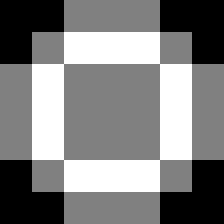

In [2]:
table = [
    [ 0, 0, 1, 1, 1, 0, 0],
    [ 0, 1, 2, 2, 2, 1, 0],
    [ 1, 2, 1, 1, 1, 2, 1],
    [ 1, 2, 1, 1, 1, 2, 1],
    [ 1, 2, 1, 1, 1, 2, 1],
    [ 0, 1, 2, 2, 2, 1, 0],
    [ 0, 0, 1, 1, 1, 0, 0]
]

table_image(table)

#### Exercise - Pixels
<small>
* Load the **Cell Colony** sample image (*File > Open Samples > Cell Colony (31K)*)
* Activate the **Pixel Inspector** tool by clicking on <kbd>&gt;&gt;</kbd> <kbd>Pixel Inspector</kbd>
* What is the *coordinate* of the upper left corner pixel?
* What is the *intensity* of the upper left corner pixel?
</small>
![The Pixel Inspector tool in Fiji](images/screen/fiji-toolbar-pixel-inpector.png)


#### Resolution

Influence of the optical system and the digital camera system on image resolution

In [3]:
[["Optical": tile([[bl0_n32,  bl0_n16,   original ],
                   [bl4_n32,  bl4_n16,   bl4_n0   ],
                   [bl16_n32, bl16_n16,  bl16_n0  ]
                  ]),
  "Digital": tile([[original, r128_i8, r128_i4],
                   [r32_i256, r32_i8,  r32_i4 ],
                   [r16_i256, r16_i8,  r16_i4 ]
                  ])
]]


Optical,Digital


#### Image types of grayscale images in ImageJ

|  Type  |   Range               |  Numeric type  |
|--------|-----------------------|----------------|
|  8-bit |         0 - 255       |     Integer    |
| 16-bit |         0 - 65535     |     Integer    |
| 32-bit | -Infinity - +Infinity | Floating point |


#### Bit depth - Exercise

* Open the *M51 Galaxy* sample image


#### Histograms



#### Color maps / Look-up tables (LUTs)

![](images/colormap-benchmark.png)
![](images/colormap-benchmark-viridis.png)
![](images/colormap-benchmark-jet.png)
![](images/colormap-benchmark-spectrum.png)

https://imagej.net/Visualization


#### Color information

Exercise ?

#### Exercises

* What's wrong with these sample images?


#### Dimensionality / Hyperstacks

So far, we've looked at 2D images. Scientific images can contain many more dimensions:

* Channels `c`
* Z Slices `z`
* Time frames `t`

In ImageJ, multi-dimensional images are displayed as *hyperstacks*.

---

*File > Open Samples > Mitosis (26MB, 5D Stack)*


![Mitosis](images/screen/imagej-hyperstack.png)

#### File formats

A word of caution: avoid JPEG, as it produces compression artifacts

* *File > Open Samples > Leaf (36K)*
* Switch to HSB color space (*Image > Type > HSB Stack*)

Next part: [Image Processing - Filtering](02-image-processing-filtering.ipynb)